# Computing PCA using RDDs

###  PCA

The vectors that we want to analyze have length, or dimension, of 365, corresponding to the number of 
days in a year.

We want to perform [Principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis)
on these vectors. There are two steps to this process:

1. Computing the covariance matrix: this is a  simple computation. However, it takes a long time to compute and it benefits from using an RDD because it involves all of the input vectors.
2. Computing the eigenvector decomposition. this is a more complex computation, but it takes a fraction of a second because the size to the covariance matrix is $365 \times 365$, which is quite small. We do it on the head node usin `linalg`

### Computing the covariance matrix
Suppose that the data vectors are the column vectors denoted $x$ then the covariance matrix is defined to be
$$
E(x x^T)-E(x)E(x)^T
$$

Where $x x^T$ is the **outer product** of $x$ with itself.

If the data that we have is $x_1,x_2,x_n$ then the estimates we use are:
$$
\hat{E}(x x^T) = \frac{1}{n} \sum_{i=1}^n x_i x_i^T,\;\;\;\;\;
\hat{E}(x) = \frac{1}{n} \sum_{i=1}^n x_i
$$

### `nan`s in arithmetic operations
* We use an RDD of numpy arrays, instead od Dataframes.
* Why? Because numpy treats `nan` entries correctly:
  * In numpy `5+nan=5` while in dataframes `5+nan=nan`

### Performing Cov matrix on vectors with NaNs
As it happens, we often get vectors $x$ in which some, but not all, of the entries are `nan`. In such cases we sum the elements that are defined and keep a seperate counter for each entry.

In [1]:
import numpy as np

def outerProduct(X):
  """Computer outer product and indicate which locations in matrix are undefined"""
  O=np.outer(X,X)
  N=1-np.isnan(O)
  return (O,N)
def sumWithNan(M1,M2):
  """Add two pairs of (matrix,count)"""
  (X1,N1)=M1
  (X2,N2)=M2
  N=N1+N2
  X=np.nansum(np.dstack((X1,X2)),axis=2)
  return (X,N)
  

In [2]:
# computeCov recieves as input an RDD of np arrays, all of the same length, and computes the covariance matrix for that set of vectors
def computeCov(RDDin):
  RDD=RDDin.map(lambda v:np.insert(v,0,1)) # insert a 1 at the beginning of each vector so that the same 
                                           #calculation also yields the mean vector
  OuterRDD=RDD.map(outerProduct)   # separating the map and the reduce does not matter because of Spark uses lazy execution.
  (S,N)=OuterRDD.reduce(sumWithNan)

  # Unpack result and compute the covariance matrix
  print('shape of S=',S.shape,'shape of N=',N.shape)
  E=S[0,1:]
  NE=np.float64(N[0,1:])
  print('shape of E=',E.shape,'shape of NE=',NE.shape)
  Mean=E/NE
  O=S[1:,1:]
  NO=np.float64(N[1:,1:])
  Cov=O/NO - np.outer(Mean,Mean)
  # Output also the diagnal which is the variance for each day
  Var=np.array([Cov[i,i] for i in range(Cov.shape[0])])
  return {'E':E,'NE':NE,'O':O,'NO':NO,'Cov':Cov,'Mean':Mean,'Var':Var}

## Reading dataFrames from HDFS

In [3]:
%%time
%pwd
from pyspark import SparkContext
sc = SparkContext(pyFiles=['/mnt/workspace/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Section2-PCA/PCA/data_preparation/lib/numpy_pack.py'])


CPU times: user 124 ms, sys: 24 ms, total: 148 ms
Wall time: 13.6 s


In [4]:
#sc.stop()


In [5]:
!du -s /mnt/workspace/Data/*

848	/mnt/workspace/Data/US_stations.parquet
1981072	/mnt/workspace/Data/US_weather.parquet


In [10]:
!hdfs dfs -ls /weather/
!hdfs dfs -du /weather/

Found 2 items
drwxr-xr-x   - hadoop hadoop          0 2018-03-26 16:10 /weather/US_stations.parquet
drwxr-xr-x   - hadoop hadoop          0 2018-03-26 16:10 /weather/US_weather.parquet
847798      /weather/US_stations.parquet
2027712578  /weather/US_weather.parquet


In [5]:
%%time
!hdfs dfs -mkdir /weather
!hdfs dfs -copyFromLocal /mnt/workspace/Data/stations.parquet /weather/
!hdfs dfs -copyFromLocal /mnt/workspace/Data/weather.parquet /weather/

CPU times: user 312 ms, sys: 96 ms, total: 408 ms
Wall time: 14.9 s


In [7]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)

In [12]:
%%time
Query="""
SELECT measurement,count(measurement) as Count 
FROM parquet.`/weather/US_weather.parquet` 
GROUP BY measurement
"""
Counts_pdf = sqlContext.sql(Query).toPandas()
print(Counts_pdf.head(10))

  measurement   Count
0        TMIN  544447
1        TOBS  433522
2        TMAX  544460
3        SNOW  576843
4        SNWD  541223
5        PRCP  618999
CPU times: user 184 ms, sys: 8 ms, total: 192 ms
Wall time: 20.7 s


In [13]:
Counts_pdf.sort_values('Count',ascending=False,inplace=True)
_index=[i for i in range(Counts_pdf.shape[0])]
Counts_pdf['Index']=_index
Counts_pdf.set_index('Index',inplace=True)
Counts_pdf.head(30)

,measurement,Count
Index,,
0,PRCP,618999
1,SNOW,576843
2,TMAX,544460
3,TMIN,544447
4,SNWD,541223
5,TOBS,433522


In [14]:
Top20=list(Counts_pdf['measurement'][:20])

restrictions='\n\t or '.join(["measurement='%s'"%name for name in Top20])
print(restrictions)

measurement='PRCP'
	 or measurement='SNOW'
	 or measurement='TMAX'
	 or measurement='TMIN'
	 or measurement='SNWD'
	 or measurement='TOBS'


In [16]:
%%time
Query="""
SELECT *
FROM parquet.`/weather/US_weather.parquet` 
WHERE ("""+restrictions+")" # and Station='USW00093819'"
print(Query)
Weather_df = sqlContext.sql(Query).cache()
print 'number of records=',Weather_df.count()


SELECT *
FROM parquet.`/weather/US_weather.parquet` 
WHERE (measurement='PRCP'
	 or measurement='SNOW'
	 or measurement='TMAX'
	 or measurement='TMIN'
	 or measurement='SNWD'
	 or measurement='TOBS')
number of records= 3259494
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 11.6 s


In [17]:
%%time
Weather_df.show(2)

+-----------+-----------+----+--------------------+
|    Station|Measurement|Year|              Values|
+-----------+-----------+----+--------------------+
|CA001126150|       PRCP|1941|[00 7E 00 7E 00 7...|
|CA001126150|       PRCP|1942|[00 00 80 4A 00 0...|
+-----------+-----------+----+--------------------+
only showing top 2 rows

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 149 ms


In [18]:
import sys
sys.path.append('./lib')
from numpy_pack import unpackArray

import numpy as np

In [19]:
from pyspark.sql.types import ArrayType,FloatType, DoubleType, StringType, IntegerType
from pyspark.sql.functions import udf
import numpy as np
def Count_nan(V):
    A=unpackArray(V,data_type=np.float16)
    return int(sum(np.isnan(A)))  # the int() is important, sparksql does not accept numpy ints
Count_nan_udf = udf(Count_nan,IntegerType())
sqlContext.registerFunction("UnpackArray", Count_nan,IntegerType())
sqlContext.registerDataFrameAsTable(Weather_df,'weather')

In [20]:
A,=Weather_df.take(1)
V=A.Values
array=unpackArray(V,data_type=np.float16)
sum(np.isnan(array))

90

In [21]:
Weather_df=Weather_df.withColumn("nan_no", Count_nan_udf(Weather_df.Values))

In [22]:
Weather_df.count()

3259494

In [23]:
Weather_df.schema

StructType(List(StructField(Station,StringType,true),StructField(Measurement,StringType,true),StructField(Year,IntegerType,true),StructField(Values,BinaryType,true),StructField(nan_no,IntegerType,true)))

In [ ]:
%%time
Weather_df.take(1)

In [114]:
Top20

[u'PRCP',
 u'TMIN',
 u'TMAX',
 u'SNOW',
 u'SNWD',
 u'TOBS',
 u'MDPR',
 u'DAPR',
 u'WT03',
 u'WT01',
 u'DWPR',
 u'WT04',
 u'WT05',
 u'WT11',
 u'WT06',
 u'WT16',
 u'WESD',
 u'WT08',
 u'WT18',
 u'WT14']

In [98]:
nan_rdd=Weather_df.select(['Station','Measurement','Year','nan_no']).rdd.cache()

In [99]:
nan_rdd.count()

8834377

In [100]:
def map_to_hist(n):
    a=np.zeros(366)
    a[n]=1
    return a
by_measurement=nan_rdd.map(lambda row: (row.Measurement,map_to_hist(row.nan_no))).cache()
#by_measurement.take(2)

[(u'WESD',
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [102]:
Hists=by_measurement.reduceByKey(lambda x,y:x+y).collect()

## Manipulating as DataFrames
using UDF

In [106]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/mnt/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['array']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [113]:
HistMap={a:b for a,b in Hists}
HistMap.keys()

[u'WT11',
 u'TMIN',
 u'WT14',
 u'TOBS',
 u'WT06',
 u'TMAX',
 u'SNOW',
 u'DAPR',
 u'WT16',
 u'DWPR',
 u'SNWD',
 u'WT04',
 u'WT05',
 u'WESD',
 u'WT18',
 u'PRCP',
 u'WT01',
 u'MDPR',
 u'WT03',
 u'WT08']

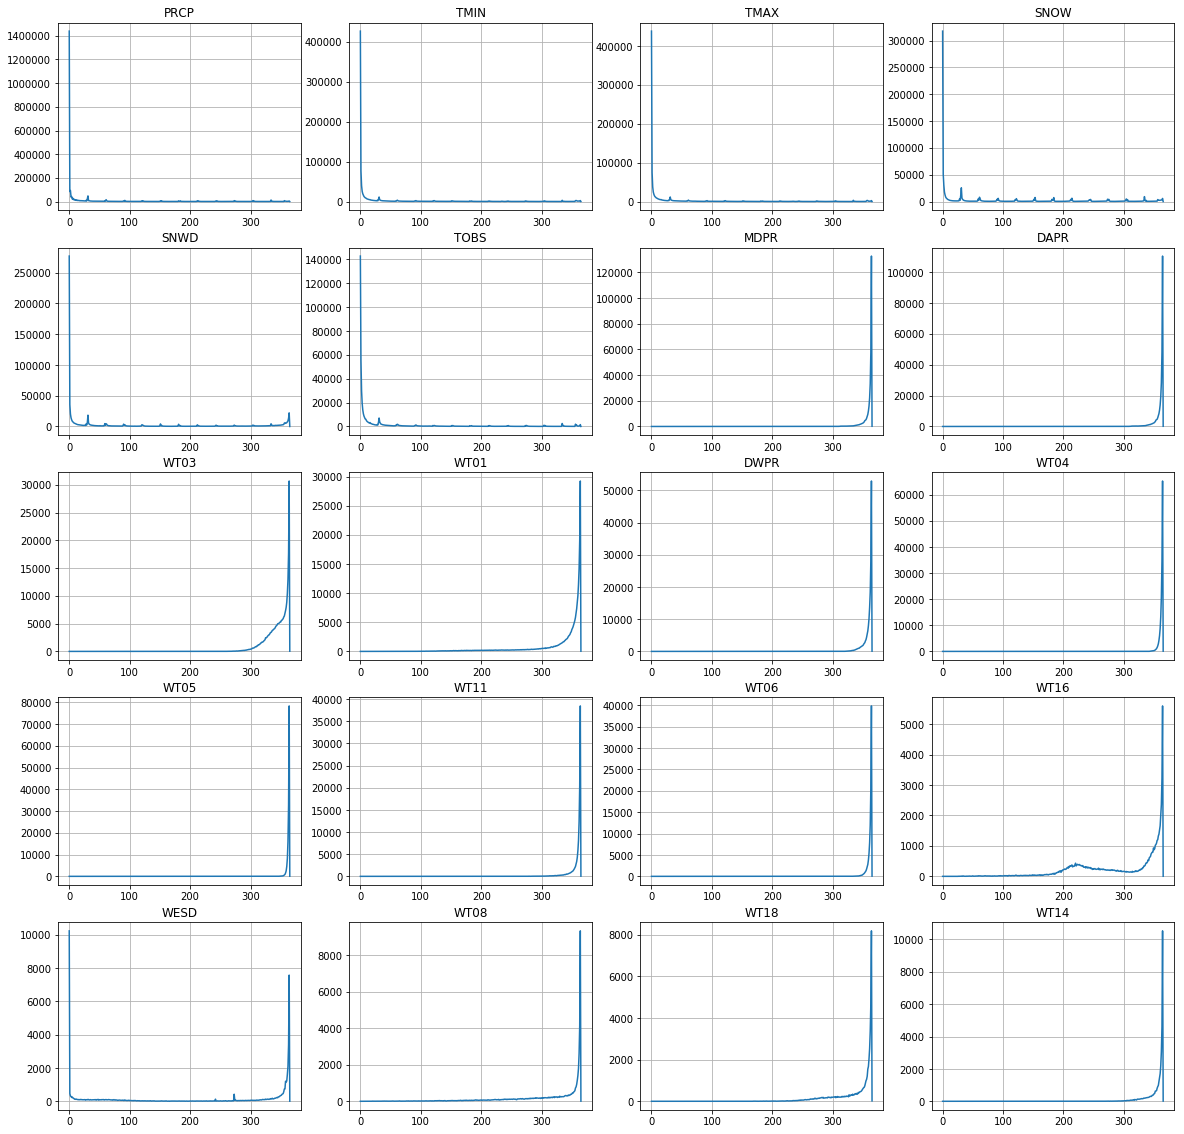

In [115]:
figure(figsize=[20,20])
for i in range(len(Hists)):
    measurement=Top20[i]
    subplot(5,4,i+1)
    plot(HistMap[measurement])
    title(measurement)
    grid()


In [17]:
from pyspark.sql.types import ArrayType,FloatType
from pyspark.sql.functions import udf

In [18]:
def Unpack(V):
    A=unpackArray(V,data_type=np.float16)
    return np.array(A,dtype=np.float32)
Unpack_udf = udf(Unpack, ArrayType(FloatType()))

In [19]:
sqlContext.registerDataFrameAsTable(Weather_df,'weather')

In [20]:
Weather_df2=Weather_df.withColumn('Array',Unpack_udf(Weather_df.Values))

In [27]:
Weather_df2.take(1)

Py4JJavaError: An error occurred while calling o64.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 9.0 failed 4 times, most recent failure: Lost task 0.3 in stage 9.0 (TID 249, ip-10-129-237-38.ec2.internal, executor 11): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/mnt/yarn/usercache/hadoop/appcache/application_1520350884886_0001/container_1520350884886_0001_01_000017/pyspark.zip/pyspark/worker.py", line 123, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.6, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:144)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:87)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:797)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:797)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:338)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1708)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1696)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1695)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1695)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:855)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:855)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:855)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1867)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:671)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2029)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2050)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2069)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:336)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply$mcI$sp(Dataset.scala:2808)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2805)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2805)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2828)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:2805)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/mnt/yarn/usercache/hadoop/appcache/application_1520350884886_0001/container_1520350884886_0001_01_000017/pyspark.zip/pyspark/worker.py", line 123, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.6, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:144)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:87)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:797)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:797)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:338)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


## Undef Statistics

## Computing the statistics

In [8]:
STAT_Descriptions=[
('SortedVals', 'Sample of values', 'vector whose length varies between measurements'),
 ('UnDef', 'sample of number of undefs per row', 'vector whose length varies between measurements'),
 ('mean', 'mean value', ()),
 ('std', 'std', ()),
 ('low100', 'bottom 1%', ()),
 ('high100', 'top 1%', ()),
 ('low1000', 'bottom 0.1%', ()),
 ('high1000', 'top 0.1%', ()),
 ('E', 'Sum of values per day', (365,)),
 ('NE', 'count of values per day', (365,)),
 ('Mean', 'E/NE', (365,)),
 ('O', 'Sum of outer products', (365, 365)),
 ('NO', 'counts for outer products', (365, 365)),
 ('Cov', 'O/NO', (365, 365)),
 ('Var', 'The variance per day = diagonal of Cov', (365,)),
 ('eigval', 'PCA eigen-values', (365,)),
 ('eigvec', 'PCA eigen-vectors', (365, 365))
  ]

In [11]:
US_Weather_parquet='/weather.parquet'
measurements=['TMAX','TMIN','TOBS','SNOW','SNWD','PRCP']
Query="SELECT * FROM parquet.`%s`\n\tWHERE "%US_Weather_parquet+"\n\tor ".join(["measurement='%s'"%m for m in measurements])
print Query

SELECT * FROM parquet.`/US_Weather.parquet`
	WHERE measurement='TMAX'
	or measurement='TMIN'
	or measurement='TOBS'
	or measurement='SNOW'
	or measurement='SNWD'
	or measurement='PRCP'


In [20]:
t=time()
df = sqlContext.sql(Query).cache()
print df.count()
print 'took',time()-t,'seconds'

took 24.3902518749 seconds


In [21]:
print df.count()

4351091


In [37]:

t=time()

N=sc.defaultParallelism
print 'Number of executors=',N
rdd0=df.rdd.map(lambda row:(str(row['station']),((str(row['measurement'])\
                        ,row['year']),np.array([np.float64(row[str(i)]) for i in range(1,366)])))).cache()#.repartition(N)
print 'took',time()-t,'seconds'

Number of executors= 80
took 0.0116009712219 seconds


In [39]:
import numpy as np
def F(row):
    return (str(row['station']),((str(row['measurement'])\
                        ,row['year']),np.array([np.float64(row[str(i)]) for i in range(1,366)])))
row,=df.take(1)
#print F(row)

In [40]:
t=time()
print rdd0.count()
print 'took',time()-t,'seconds'

4351091
took 321.376906872 seconds


In [43]:
t=time()
print rdd0.count()
print 'took',time()-t,'seconds'

4351091
took 1.04327487946 seconds


In [44]:
t=time()
print rdd0.repartition(N).count()
print 'took',time()-t,'seconds'

4351091
took 5.36106610298 seconds


In [45]:
# Compute the overall distribution of values and the distribution of the number of nan per year
def find_percentiles(SortedVals,percentile):
  L=len(SortedVals)/percentile
  return SortedVals[L],SortedVals[-L]
  
def computeOverAllDist(rdd0):
  UnDef=np.array(rdd0.map(lambda row:sum(np.isnan(row))).sample(False,0.01).collect())
  flat=rdd0.flatMap(lambda v:list(v)).filter(lambda x: not np.isnan(x)).cache()
  count,S1,S2=flat.map(lambda x: np.float64([1,x,x**2]))\
                  .reduce(lambda x,y: x+y)
  mean=S1/count
  std=np.sqrt(S2/count-mean**2)
  Vals=flat.sample(False,0.0001).collect()
  SortedVals=np.array(sorted(Vals))
  low100,high100=find_percentiles(SortedVals,100)
  low1000,high1000=find_percentiles(SortedVals,1000)
  return {'UnDef':UnDef,\
          'mean':mean,\
          'std':std,\
          'SortedVals':SortedVals,\
          'low100':low100,\
          'high100':high100,\
          'low1000':low100,\
          'high1000':high1000
          }

In [ ]:
from numpy import linalg as LA

STAT={}  # dictionary storing the statistics for each measurement
Clean_Tables={}

for meas in measurements:
  t=time()
  Query="SELECT * FROM parquet.`%s`\n\tWHERE measurement = '%s'"%(US_Weather_parquet,meas)
  print Query
  df = sqlContext.sql(Query)
  rdd0=df.rdd.map(lambda row:(row['station'],((row['measurement'],row['year']),np.array([np.float64(row[str(i)]) for i in range(1,366)])))).cache()

  rdd1=rdd0.sample(False,1)\
           .map(lambda (key,val): val[1])\
           .cache()\
           .repartition(N)
  print rdd1.count()

  #get basic statistics
  STAT[meas]=computeOverAllDist(rdd1)   # Compute the statistics 
  low1000 = STAT[meas]['low1000']  # unpack the extreme values statistics
  high1000 = STAT[meas]['high1000']

  #clean up table from extreme values and from rows with too many undefinde entries.
  rdd2=rdd1.map(lambda V: np.array([x if (x>low1000-1) and (x<high1000+1) else np.nan for x in V]))
  rdd3=rdd2.filter(lambda row:sum(np.isnan(row))<50)
  Clean_Tables[meas]=rdd3.cache().repartition(N)
  C=Clean_Tables[meas].count()
  print 'for measurement %s, we get %d clean rows'%(meas,C)

  # compute covariance matrix
  OUT=computeCov(Clean_Tables[meas])

  #find PCA decomposition
  eigval,eigvec=LA.eig(OUT['Cov'])

  # collect all of the statistics in STAT[meas]
  STAT[meas]['eigval']=eigval
  STAT[meas]['eigvec']=eigvec
  STAT[meas].update(OUT)

  # print summary of statistics
  print 'the statistics for %s consists of:'%meas
  for key in STAT[meas].keys():
    e=STAT[meas][key]
    if type(e)==list:
      print key,'list',len(e)
    elif type(e)==np.ndarray:
      print key,'ndarray',e.shape
    elif type(e)==np.float64:
      print key,'scalar'
    else:
      print key,'Error type=',type(e)
  print 'time for',meas,'is',time()-t

SELECT * FROM parquet.`/US_Weather.parquet`
	WHERE measurement = 'TMAX'
662767
for measurement TMAX, we get 551661 clean rows
shape of S= (366, 366) shape of N= (366, 366)
shape of E= (365,) shape of NE= (365,)
the statistics for TMAX consists of:
E ndarray (365,)
Cov ndarray (365, 365)
O ndarray (365, 365)
NE ndarray (365,)
Var ndarray (365,)
SortedVals ndarray (22125,)
Mean ndarray (365,)
std scalar
UnDef ndarray (6689,)
eigval ndarray (365,)
high1000 scalar
NO ndarray (365, 365)
low100 scalar
high100 scalar
low1000 scalar
mean scalar
eigvec ndarray (365, 365)
time for TMAX is 218.555129051
SELECT * FROM parquet.`/US_Weather.parquet`
	WHERE measurement = 'TMIN'
662742
for measurement TMIN, we get 548833 clean rows
shape of S= (366, 366) shape of N= (366, 366)
shape of E= (365,) shape of NE= (365,)
the statistics for TMIN consists of:
E ndarray (365,)
Cov ndarray (365, 365)
O ndarray (365, 365)
NE ndarray (365,)
Var ndarray (365,)
SortedVals ndarray (22144,)
Mean ndarray (365,)
std sc

In [72]:
from pickle import dump
def dumpS3(object,S3dir,filename):
    dump(object,open(filename,'wb'))
    !ls -l $filename
    s3helper.local_to_s3(filename, S3dir+filename)
dumpS3((STAT,STAT_Descriptions),'/Weather/','STAT1.pickle')


-rw-rw-r-- 1 ec2-user ec2-user 81729695 Mar  9 06:09 STAT1.pickle


In [65]:
STAT.keys()

['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']

### Sample Stations
Generate a sample of stations, for each one store all available year X measurement pairs.

In [54]:
rdd0.take(10) # test output

[(u'USC00305618',
  ((u'PRCP', 1914.0),
   array([  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
            nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
            nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
            nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
            nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
            nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
            nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
            nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
            nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
            nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
            nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
            nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
            nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           

In [73]:
groups=rdd0.groupByKey().cache()
print 'number of stations=',groups.count()

groups1=groups.sample(False,0.01).collect()
groups2=[(g[0],[e for e in g[1]]) for g in groups1]

dumpS3(groups2,'/Weather/','SampleStations.pickle')

number of stations= 45833
-rw-rw-r-- 1 ec2-user ec2-user 110449557 Mar  9 06:10 SampleStations.pickle


In [19]:
group_Sample=rdd0.sample(False,0.001).groupByKey().mapValues(list).cache()
group_Sample.first()

In [76]:
Means=rdd0.aggregateByKey((np.zeros(365),1),\
                          lambda S,D: sumWithNan(S,(D[1],1)),\
                          lambda S1,S2: sumWithNanithNan(S1,S2))\
.cache()#.repartition(N)

In [77]:
Means.take(5)

[(u'USC00213727',
  (array([[   67.,   511.,   326.,   285.,   122.,   321.,   193.,   155.,
             398.,   224.,   421.,   390.,   260.,   254.,   484.,   342.,
             249.,   124.,   133.,   194.,   232.,   228.,   267.,   546.,
             635.,   270.,    92.,   430.,   328.,   239.,   324.,    71.,
             171.,    73.,   244.,   421.,   133.,    54.,    81.,   218.,
             317.,   181.,    95.,    91.,   211.,   184.,   302.,   153.,
             175.,   244.,   188.,   272.,   115.,   330.,   452.,   159.,
             203.,   420.,   393.,   254.,   449.,   412.,   533.,   369.,
              51.,   315.,   125.,   317.,   113.,   176.,   730.,   215.,
             203.,   663.,   307.,   208.,   448.,   525.,   405.,   544.,
             310.,   295.,   365.,   206.,   585.,   391.,   570.,   331.,
             528.,   289.,   571.,   507.,   379.,   581.,   336.,   622.,
             530.,   473.,   899.,   645.,   242.,   407.,   683.,   547.,
       

In [78]:
groups=rdd0.groupByKey().cache()
print 'number of stations=',groups.count()


number of stations= 45833
